# Beyond Least Squares: Computing Gradients in PyTorch

In this notebook, we'll explore how PyTorch automates gradient computation through automatic differentiation. We'll:
1. Compare manual and automatic gradient computation
2. Understand different ways to compute gradients
3. Implement gradient descent efficiently
4. Train neural networks on real data

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib for notebook display
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

## A Simple Example: Polynomial Function

Let's start with a simple one-dimensional function to understand automatic differentiation:

$$ f(x) = x^3 - 3x $$

The manual gradient computation would be:
$$ \frac{d}{dx}f(x) = 3x^2 - 3 $$

PyTorch can compute this gradient automatically:

In [2]:
# Create input tensor with gradient tracking
x = torch.tensor([1.0], requires_grad=True)

# Forward pass: compute function value
y = x**3 - 3*x

# Backward pass: compute gradient
y.backward()

print(f"f'(1) = {x.grad}")  # Should be 0 (critical point)

f'(1) = tensor([0.])


Let's verify this matches our manual computation across different x values:

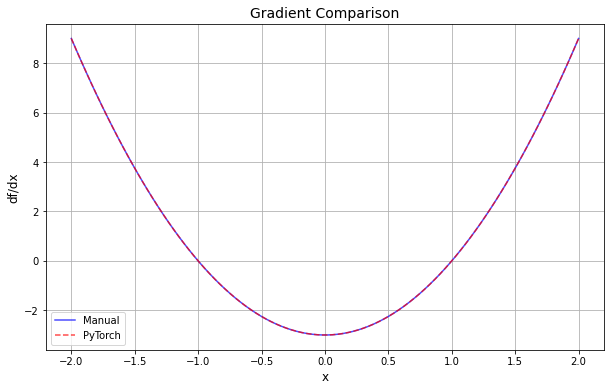

In [3]:
def manual_gradient(x):
    """Compute gradient manually"""
    return 3 * x**2 - 3

def plot_gradients():
    """Compare manual and automatic gradients"""
    x_vals = torch.linspace(-2, 2, 100)
    manual_grads = manual_gradient(x_vals)
    
    # Compute automatic gradients
    auto_grads = []
    for x_val in x_vals:
        x = torch.tensor([float(x_val)], requires_grad=True)
        y = x**3 - 3*x
        y.backward()
        auto_grads.append(x.grad.item())
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, manual_grads, 'b-', label='Manual', alpha=0.7)
    plt.plot(x_vals, auto_grads, 'r--', label='PyTorch', alpha=0.7)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('df/dx')
    plt.title('Gradient Comparison')
    plt.legend()
    plt.show()

plot_gradients()

The perfect agreement between manual and automatic gradients demonstrates PyTorch's accuracy. This automatic differentiation becomes invaluable for more complex functions where manual gradient computation would be tedious and error-prone. 

## Two Ways to Compute Gradients

PyTorch provides two main approaches for computing gradients:

1. Using `backward()`:

In [4]:
# Create graph
x = torch.tensor([1.0], requires_grad=True)
y = x**3 - 3*x

# Compute gradients
y.backward()
grad = x.grad  # Gradient stored in tensor
print(f"Using backward(): {grad}")

Using backward(): tensor([0.])


2. Using `autograd.grad()`:

In [5]:
# Create graph
x = torch.tensor([1.0], requires_grad=True)
y = x**3 - 3*x

# Direct computation
grad = torch.autograd.grad(y, x)[0]
print(f"Using autograd.grad(): {grad}")

Using autograd.grad(): tensor([0.])


The key differences are:

1. `backward()`:
   - Best for training loops
   - Stores gradients in tensors
   - Memory efficient
   - Supports gradient accumulation

2. `autograd.grad()`:
   - Best for one-off gradients
   - Direct access to gradients
   - Cleaner for higher derivatives
   - No gradient accumulation

Let's see an example of gradient accumulation with `backward()`:

In [6]:
# Reset gradients
x = torch.tensor([1.0], requires_grad=True)
y = x**3 - 3*x

# First backward pass
y.backward(retain_graph=True)  # retain_graph=True allows multiple backward passes
print(f"After first backward(): {x.grad}")

# Second backward pass (gradients accumulate!)
y.backward()
print(f"After second backward(): {x.grad}")  # Note the gradient has doubled

# Reset gradients
x.grad.zero_()
print(f"After reset: {x.grad}")

After first backward(): tensor([0.])
After second backward(): tensor([0.])
After reset: tensor([0.])


This behavior is why we need to call `zero_grad()` in training loops. In contrast, `autograd.grad()` doesn't accumulate:

In [7]:
# First example: shows error without retain_graph
x = torch.tensor([1.0], requires_grad=True)
y = x**3 - 3*x

try:
    grad1 = torch.autograd.grad(y, x)[0]
    grad2 = torch.autograd.grad(y, x)[0]  # This will raise an error
    print(f"First call: {grad1}")
    print(f"Second call: {grad2}")
except RuntimeError as e:
    print(f"Error: {e}")

# Second example: shows correct usage with retain_graph
print("\nWith retain_graph=True:")
x = torch.tensor([1.0], requires_grad=True)  # Create new graph
y = x**3 - 3*x
grad1 = torch.autograd.grad(y, x, retain_graph=True)[0]
grad2 = torch.autograd.grad(y, x)[0]
print(f"First call: {grad1}")
print(f"Second call: {grad2}")

Error: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

With retain_graph=True:
First call: tensor([0.])
Second call: tensor([0.])


## Common Pitfalls in PyTorch

There are several common mistakes that can break gradient computation or cause memory issues:

### 1. In-place Operations

In [8]:
# Create a tensor with gradients enabled
x = torch.tensor([4.0], requires_grad=True)

# Compute the square root. For sqrt, the backward pass needs the original output
y = torch.sqrt(x)  # y is 2.0, and sqrt's backward uses this value

# Show the gradient function before modification
print("Before in-place op, y.grad_fn:", y.grad_fn)

# Define another operation that uses y

try:
    # In-place modify y. This alters the saved value needed by the sqrt backward
    y.add_(1)  # Now y becomes 3.0
    print("After in-place op, y.grad_fn:", y.grad_fn)  # The grad_fn is now None
    z = 3 * y

    # Attempt to compute gradients. This will trigger a RuntimeError
    z.backward()
    print("This line won't be reached")
except RuntimeError as e:
    print(f"Error with in-place operation: {e}")

print("\nWhy did this happen?")
print("The in-place operation (y.add_(1)) modified sqrt's output")
print("This invalidated the saved value needed to compute the gradient:")
print("d/dx sqrt(x) = 1/(2*sqrt(x))")

# Correct way: use out-of-place operations
x = torch.tensor([4.0], requires_grad=True)
y = torch.sqrt(x)
# Instead of modifying y in-place, create a new tensor
y = y + 1
z = 3 * y
z.backward()  # This works fine
print("\nCorrect gradient:", x.grad)

Before in-place op, y.grad_fn: <SqrtBackward0 object at 0x107e174f0>
After in-place op, y.grad_fn: <AddBackward0 object at 0x107eb24d0>
Error with in-place operation: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1]], which is output 0 of SqrtBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

Why did this happen?
The in-place operation (y.add_(1)) modified sqrt's output
This invalidated the saved value needed to compute the gradient:
d/dx sqrt(x) = 1/(2*sqrt(x))

Correct gradient: tensor([0.7500])


### 2. Memory Management

The `torch.no_grad()` context manager is crucial for memory efficiency:

In [9]:
# Create large tensors
X = torch.randn(1000, 1000, requires_grad=True)
y = torch.randn(1000)

def compute_loss(X, y):
    return ((X @ X.t() @ y - y)**2).sum()

# Memory inefficient: tracks all computations
loss1 = compute_loss(X, y)

# Memory efficient: no gradient tracking during evaluation
with torch.no_grad():
    loss2 = compute_loss(X, y)

print(f"Gradient tracking: {loss1.requires_grad}")
print(f"No gradient tracking: {loss2.requires_grad}")

Gradient tracking: True
No gradient tracking: False


### 3. Gradient Accumulation

When training with multiple backward passes, remember to zero gradients:

In [10]:
x = torch.tensor([1.0], requires_grad=True)
optimizer = torch.optim.SGD([x], lr=0.1)

for _ in range(2):
    y = x**2
    
    # Wrong: gradients accumulate
    y.backward(retain_graph=True)  # Need retain_graph=True for multiple backward passes
    print(f"Accumulated gradient: {x.grad}")
    
    # Correct: zero gradients before backward
    optimizer.zero_grad()
    y = x**2  # Need to recompute y since previous backward consumed the graph
    y.backward()
    print(f"Clean gradient: {x.grad}")
    
    optimizer.step()

Accumulated gradient: tensor([2.])
Clean gradient: tensor([2.])
Accumulated gradient: tensor([3.6000])
Clean gradient: tensor([1.6000])


These patterns become especially important when training deep networks where mistakes can be harder to debug. 

## Least Squares Gradients

Let's compare manual and automatic gradient computation for least squares regression:

$$ f(w) = \frac{1}{2}\|Xw - y\|^2 $$

The manual gradient is:
$$ \nabla f = X^\top(Xw - y) $$

Let's implement both approaches:

In [11]:
# Generate synthetic data
n, p = 100, 5
X = torch.randn(n, p)
w_true = torch.randn(p)
y = X @ w_true + 0.1 * torch.randn(n)

def manual_gradient(X, y, w):
    """Compute least squares gradient manually"""
    return X.T @ (X @ w - y)

def pytorch_gradient(X, y, w):
    """Compute least squares gradient using PyTorch"""
    w = w.clone().requires_grad_(True)
    f = 0.5 * torch.sum((X @ w - y)**2)
    f.backward()
    return w.grad

# Compare gradients
w = torch.randn(p)
grad_manual = manual_gradient(X, y, w)
grad_pytorch = pytorch_gradient(X, y, w)

print("Manual gradient:", grad_manual)
print("PyTorch gradient:", grad_pytorch)
print("Maximum difference:", torch.max(torch.abs(grad_manual - grad_pytorch)))

Manual gradient: tensor([ 181.4544,   17.5285,   44.8792, -267.6077,    6.6792])
PyTorch gradient: tensor([ 181.4544,   17.5285,   44.8792, -267.6077,    6.6792])
Maximum difference: tensor(0.)


Let's visualize how these gradients evolve during optimization:

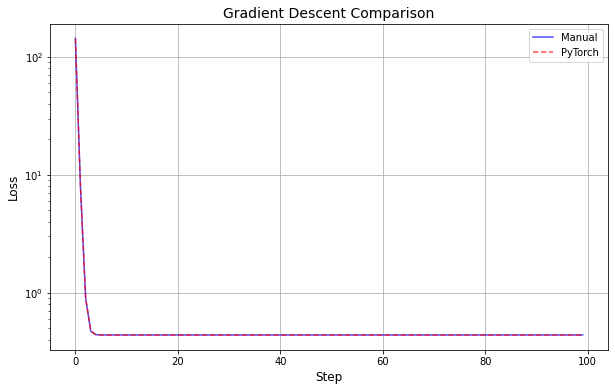

In [12]:
def compare_gradient_descent():
    """Compare manual and PyTorch gradient descent"""
    # Initialize parameters
    w_manual = torch.randn(p)
    w_pytorch = w_manual.clone()
    alpha = 0.01
    n_steps = 100
    
    # Track losses
    manual_losses = []
    pytorch_losses = []
    
    for step in range(n_steps):
        # Manual update
        loss_manual = 0.5 * torch.sum((X @ w_manual - y)**2)
        grad_manual = manual_gradient(X, y, w_manual)
        w_manual = w_manual - alpha * grad_manual
        manual_losses.append(loss_manual.item())
        
        # PyTorch update
        w_pytorch.requires_grad_(True)
        loss_pytorch = 0.5 * torch.sum((X @ w_pytorch - y)**2)
        loss_pytorch.backward()
        with torch.no_grad():
            w_pytorch = w_pytorch - alpha * w_pytorch.grad
            w_pytorch.grad = None
        pytorch_losses.append(loss_pytorch.item())
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.semilogy(manual_losses, 'b-', label='Manual', alpha=0.7)
    plt.semilogy(pytorch_losses, 'r--', label='PyTorch', alpha=0.7)
    plt.grid(True)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Gradient Descent Comparison')
    plt.legend()
    plt.show()

compare_gradient_descent()

The identical convergence paths confirm that PyTorch's automatic differentiation gives us exactly the same gradients as manual computation, but without the need to derive and implement gradients by hand. 

## MNIST Classification

Now let's apply these concepts to a real problem: classifying MNIST digits as odd or even. We'll compare logistic regression with a simple neural network.

### Data Loading and Preprocessing

In [13]:
print("Loading MNIST dataset...")
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Sample subset for faster training
n_samples = 5000
n_val = 1000
train_indices = torch.randperm(len(train_dataset))[:n_samples]

def get_binary_data(dataset, indices):
    """Convert MNIST to binary classification (odd vs even)"""
    X, y, raw_images = [], [], []
    subset = torch.utils.data.Subset(dataset, indices)
    
    for img, label in subset:
        X.append(img.view(-1))
        y.append(label % 2)  # 0 for even, 1 for odd
        raw_images.append(img.clone())
    
    return (torch.stack(X),
            torch.tensor(y, dtype=torch.float32),
            torch.stack(raw_images))

# Prepare training data
X_train, y_train, raw_images_train = get_binary_data(train_dataset, train_indices[:-n_val])
X_val, y_val, raw_images_val = get_binary_data(train_dataset, train_indices[-n_val:])

Loading MNIST dataset...


### Model Definitions

In [14]:
class Logistic(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, 1, bias=False)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

class SimpleNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 32)
        self.fc2 = torch.nn.Linear(32, 1)
        
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(h))

# Initialize models
n_features = 784
logistic_model = Logistic(n_features)
neural_net = SimpleNN()

### Training Loop

In [15]:
def compute_metrics(model, X, y, criterion):
    """Compute loss and accuracy"""
    with torch.no_grad():
        y_pred = model(X)
        y_pred = y_pred.squeeze()
        
        loss = criterion(y_pred, y).item()
        preds = (y_pred >= 0.5).float()
        acc = (preds == y).float().mean().item()
    return loss, acc, preds

def train_model(model, X_train, y_train, X_val, y_val, alpha=0.01, n_steps=1000):
    """Train model and track metrics"""
    criterion = torch.nn.BCELoss()
    metrics = {'train_loss': [], 'train_acc': [], 
              'val_loss': [], 'val_acc': [], 'iterations': []}
    
    for step in range(n_steps):
        y_pred = model(X_train)
        loss = criterion(y_pred.squeeze(), y_train)
            
        loss.backward()
        
        with torch.no_grad():
            for param in model.parameters():
                param -= alpha * param.grad
                param.grad.zero_()
        
        if step % 10 == 0:
            train_loss, train_acc, train_preds = compute_metrics(
                model, X_train, y_train, criterion)
            val_loss, val_acc, val_preds = compute_metrics(
                model, X_val, y_val, criterion)
            
            metrics['train_loss'].append(train_loss)
            metrics['train_acc'].append(train_acc)
            metrics['val_loss'].append(val_loss)
            metrics['val_acc'].append(val_acc)
            metrics['iterations'].append(step)
            
            print(f"Step {step}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    
    return metrics

print("\nTraining logistic regression...")
logistic_metrics = train_model(logistic_model, X_train, y_train, X_val, y_val)

print("\nTraining neural network...")
nn_metrics = train_model(neural_net, X_train, y_train, X_val, y_val)


Training logistic regression...
Step 0, Loss: 0.6916, Acc: 0.5560
Step 10, Loss: 0.4943, Acc: 0.7943


Step 20, Loss: 0.4324, Acc: 0.8240
Step 30, Loss: 0.4014, Acc: 0.8340
Step 40, Loss: 0.3823, Acc: 0.8428
Step 50, Loss: 0.3692, Acc: 0.8470
Step 60, Loss: 0.3595, Acc: 0.8520


Step 70, Loss: 0.3519, Acc: 0.8555
Step 80, Loss: 0.3458, Acc: 0.8562
Step 90, Loss: 0.3407, Acc: 0.8597
Step 100, Loss: 0.3363, Acc: 0.8620
Step 110, Loss: 0.3326, Acc: 0.8620
Step 120, Loss: 0.3293, Acc: 0.8635
Step 130, Loss: 0.3263, Acc: 0.8650
Step 140, Loss: 0.3237, Acc: 0.8665
Step 150, Loss: 0.3213, Acc: 0.8675
Step 160, Loss: 0.3191, Acc: 0.8687
Step 170, Loss: 0.3171, Acc: 0.8695
Step 180, Loss: 0.3153, Acc: 0.8698
Step 190, Loss: 0.3135, Acc: 0.8705
Step 200, Loss: 0.3119, Acc: 0.8730
Step 210, Loss: 0.3104, Acc: 0.8733
Step 220, Loss: 0.3090, Acc: 0.8748
Step 230, Loss: 0.3077, Acc: 0.8758
Step 240, Loss: 0.3064, Acc: 0.8763
Step 250, Loss: 0.3052, Acc: 0.8770
Step 260, Loss: 0.3041, Acc: 0.8767
Step 270, Loss: 0.3030, Acc: 0.8775
Step 280, Loss: 0.3019, Acc: 0.8777
Step 290, Loss: 0.3009, Acc: 0.8780
Step 300, Loss: 0.3000, Acc: 0.8780
Step 310, Loss: 0.2991, Acc: 0.8785
Step 320, Loss: 0.2982, Acc: 0.8788
Step 330, Loss: 0.2973, Acc: 0.8788
Step 340, Loss: 0.2965, Acc: 0.

Step 380, Loss: 0.2935, Acc: 0.8795
Step 390, Loss: 0.2928, Acc: 0.8800
Step 400, Loss: 0.2921, Acc: 0.8802
Step 410, Loss: 0.2915, Acc: 0.8810
Step 420, Loss: 0.2908, Acc: 0.8813
Step 430, Loss: 0.2902, Acc: 0.8820
Step 440, Loss: 0.2896, Acc: 0.8827
Step 450, Loss: 0.2890, Acc: 0.8830
Step 460, Loss: 0.2884, Acc: 0.8838
Step 470, Loss: 0.2878, Acc: 0.8842
Step 480, Loss: 0.2873, Acc: 0.8845
Step 490, Loss: 0.2867, Acc: 0.8848
Step 500, Loss: 0.2862, Acc: 0.8848
Step 510, Loss: 0.2857, Acc: 0.8850
Step 520, Loss: 0.2852, Acc: 0.8852
Step 530, Loss: 0.2847, Acc: 0.8857
Step 540, Loss: 0.2842, Acc: 0.8860
Step 550, Loss: 0.2837, Acc: 0.8865
Step 560, Loss: 0.2832, Acc: 0.8870
Step 570, Loss: 0.2828, Acc: 0.8870
Step 580, Loss: 0.2823, Acc: 0.8870
Step 590, Loss: 0.2819, Acc: 0.8878
Step 600, Loss: 0.2815, Acc: 0.8882
Step 610, Loss: 0.2810, Acc: 0.8882
Step 620, Loss: 0.2806, Acc: 0.8890
Step 630, Loss: 0.2802, Acc: 0.8890
Step 640, Loss: 0.2798, Acc: 0.8892
Step 650, Loss: 0.2794, Acc:

Step 780, Loss: 0.2747, Acc: 0.8910
Step 790, Loss: 0.2744, Acc: 0.8907
Step 800, Loss: 0.2741, Acc: 0.8910
Step 810, Loss: 0.2737, Acc: 0.8913
Step 820, Loss: 0.2734, Acc: 0.8915
Step 830, Loss: 0.2731, Acc: 0.8915
Step 840, Loss: 0.2728, Acc: 0.8915
Step 850, Loss: 0.2725, Acc: 0.8915
Step 860, Loss: 0.2722, Acc: 0.8915
Step 870, Loss: 0.2719, Acc: 0.8917
Step 880, Loss: 0.2716, Acc: 0.8928
Step 890, Loss: 0.2713, Acc: 0.8930
Step 900, Loss: 0.2710, Acc: 0.8928
Step 910, Loss: 0.2708, Acc: 0.8928
Step 920, Loss: 0.2705, Acc: 0.8928
Step 930, Loss: 0.2702, Acc: 0.8925
Step 940, Loss: 0.2699, Acc: 0.8925
Step 950, Loss: 0.2697, Acc: 0.8925
Step 960, Loss: 0.2694, Acc: 0.8928
Step 970, Loss: 0.2691, Acc: 0.8930
Step 980, Loss: 0.2689, Acc: 0.8932
Step 990, Loss: 0.2686, Acc: 0.8932

Training neural network...
Step 0, Loss: 0.6713, Acc: 0.6463
Step 10, Loss: 0.6256, Acc: 0.7638
Step 20, Loss: 0.5809, Acc: 0.8012
Step 30, Loss: 0.5397, Acc: 0.8185


Step 40, Loss: 0.5031, Acc: 0.8267
Step 50, Loss: 0.4719, Acc: 0.8345
Step 60, Loss: 0.4458, Acc: 0.8407
Step 70, Loss: 0.4242, Acc: 0.8432
Step 80, Loss: 0.4064, Acc: 0.8460
Step 90, Loss: 0.3917, Acc: 0.8495
Step 100, Loss: 0.3796, Acc: 0.8520


Step 110, Loss: 0.3696, Acc: 0.8540
Step 120, Loss: 0.3610, Acc: 0.8568
Step 130, Loss: 0.3537, Acc: 0.8597
Step 140, Loss: 0.3473, Acc: 0.8627
Step 150, Loss: 0.3416, Acc: 0.8640
Step 160, Loss: 0.3365, Acc: 0.8668
Step 170, Loss: 0.3320, Acc: 0.8683
Step 180, Loss: 0.3279, Acc: 0.8690
Step 190, Loss: 0.3241, Acc: 0.8710
Step 200, Loss: 0.3205, Acc: 0.8715


Step 210, Loss: 0.3172, Acc: 0.8723
Step 220, Loss: 0.3141, Acc: 0.8725
Step 230, Loss: 0.3112, Acc: 0.8745
Step 240, Loss: 0.3085, Acc: 0.8748
Step 250, Loss: 0.3058, Acc: 0.8760
Step 260, Loss: 0.3033, Acc: 0.8773
Step 270, Loss: 0.3008, Acc: 0.8773
Step 280, Loss: 0.2985, Acc: 0.8777
Step 290, Loss: 0.2962, Acc: 0.8785


Step 300, Loss: 0.2940, Acc: 0.8800
Step 310, Loss: 0.2919, Acc: 0.8815
Step 320, Loss: 0.2898, Acc: 0.8832
Step 330, Loss: 0.2877, Acc: 0.8840
Step 340, Loss: 0.2857, Acc: 0.8852
Step 350, Loss: 0.2837, Acc: 0.8860
Step 360, Loss: 0.2818, Acc: 0.8890


Step 370, Loss: 0.2799, Acc: 0.8907
Step 380, Loss: 0.2779, Acc: 0.8907
Step 390, Loss: 0.2761, Acc: 0.8917
Step 400, Loss: 0.2742, Acc: 0.8925
Step 410, Loss: 0.2723, Acc: 0.8938
Step 420, Loss: 0.2705, Acc: 0.8938
Step 430, Loss: 0.2687, Acc: 0.8945
Step 440, Loss: 0.2668, Acc: 0.8957
Step 450, Loss: 0.2651, Acc: 0.8972
Step 460, Loss: 0.2633, Acc: 0.8980


Step 470, Loss: 0.2615, Acc: 0.8988
Step 480, Loss: 0.2597, Acc: 0.8992
Step 490, Loss: 0.2580, Acc: 0.8997
Step 500, Loss: 0.2562, Acc: 0.9005
Step 510, Loss: 0.2545, Acc: 0.9015
Step 520, Loss: 0.2527, Acc: 0.9022
Step 530, Loss: 0.2510, Acc: 0.9025
Step 540, Loss: 0.2493, Acc: 0.9035
Step 550, Loss: 0.2476, Acc: 0.9055
Step 560, Loss: 0.2459, Acc: 0.9065


Step 570, Loss: 0.2442, Acc: 0.9075
Step 580, Loss: 0.2425, Acc: 0.9090
Step 590, Loss: 0.2408, Acc: 0.9100
Step 600, Loss: 0.2391, Acc: 0.9110
Step 610, Loss: 0.2375, Acc: 0.9128
Step 620, Loss: 0.2358, Acc: 0.9130
Step 630, Loss: 0.2341, Acc: 0.9150
Step 640, Loss: 0.2325, Acc: 0.9165
Step 650, Loss: 0.2308, Acc: 0.9172


Step 660, Loss: 0.2291, Acc: 0.9178
Step 670, Loss: 0.2275, Acc: 0.9185
Step 680, Loss: 0.2259, Acc: 0.9200
Step 690, Loss: 0.2243, Acc: 0.9205


Step 700, Loss: 0.2227, Acc: 0.9205
Step 710, Loss: 0.2211, Acc: 0.9227
Step 720, Loss: 0.2195, Acc: 0.9235
Step 730, Loss: 0.2179, Acc: 0.9237
Step 740, Loss: 0.2163, Acc: 0.9250
Step 750, Loss: 0.2147, Acc: 0.9255


Step 760, Loss: 0.2132, Acc: 0.9273
Step 770, Loss: 0.2116, Acc: 0.9280
Step 780, Loss: 0.2101, Acc: 0.9293
Step 790, Loss: 0.2085, Acc: 0.9305
Step 800, Loss: 0.2070, Acc: 0.9308
Step 810, Loss: 0.2055, Acc: 0.9317


Step 820, Loss: 0.2040, Acc: 0.9323
Step 830, Loss: 0.2025, Acc: 0.9335
Step 840, Loss: 0.2010, Acc: 0.9337
Step 850, Loss: 0.1995, Acc: 0.9345
Step 860, Loss: 0.1980, Acc: 0.9340
Step 870, Loss: 0.1965, Acc: 0.9345


Step 880, Loss: 0.1951, Acc: 0.9352
Step 890, Loss: 0.1936, Acc: 0.9358
Step 900, Loss: 0.1922, Acc: 0.9362
Step 910, Loss: 0.1908, Acc: 0.9365
Step 920, Loss: 0.1894, Acc: 0.9375
Step 930, Loss: 0.1880, Acc: 0.9380


Step 940, Loss: 0.1866, Acc: 0.9390
Step 950, Loss: 0.1853, Acc: 0.9395
Step 960, Loss: 0.1839, Acc: 0.9405
Step 970, Loss: 0.1826, Acc: 0.9415
Step 980, Loss: 0.1813, Acc: 0.9423
Step 990, Loss: 0.1800, Acc: 0.9440


### Results Analysis

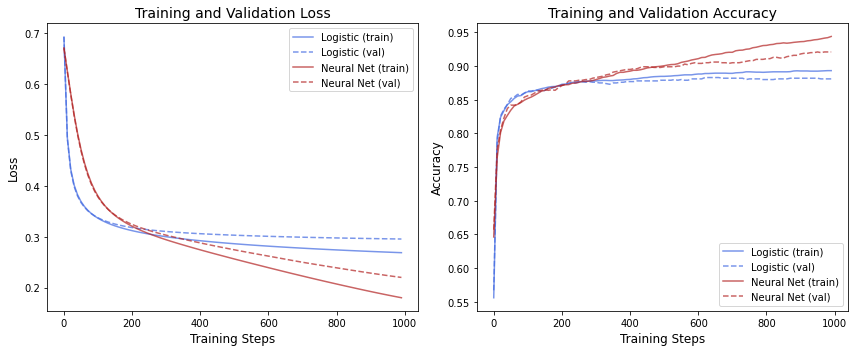


Model Performance Analysis:
1. Logistic Regression:
   - Test Accuracy: 88.10%
   - Uses linear decision boundary
   - Faster training, simpler model

2. Neural Network:
   - Test Accuracy: 92.10%
   - Non-linear decision boundary via hidden layer
   - Better performance but more complex

Key Findings:
1. Neural network outperforms logistic regression by 4.00% on test set
2. Both models achieve good performance, showing the task is learnable
3. The neural network's non-linear decision boundary allows it to capture more complex patterns


In [16]:
def plot_training_curves(logistic_metrics, nn_metrics):
    """Plot training curves comparing both models"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot loss curves
    ax1.plot(logistic_metrics['iterations'], logistic_metrics['train_loss'],
             label='Logistic (train)', color='royalblue', alpha=0.7)
    ax1.plot(logistic_metrics['iterations'], logistic_metrics['val_loss'],
             label='Logistic (val)', color='royalblue', linestyle='--', alpha=0.7)
    ax1.plot(nn_metrics['iterations'], nn_metrics['train_loss'],
             label='Neural Net (train)', color='firebrick', alpha=0.7)
    ax1.plot(nn_metrics['iterations'], nn_metrics['val_loss'],
             label='Neural Net (val)', color='firebrick', linestyle='--', alpha=0.7)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy curves
    ax2.plot(logistic_metrics['iterations'], logistic_metrics['train_acc'],
             label='Logistic (train)', color='royalblue', alpha=0.7)
    ax2.plot(logistic_metrics['iterations'], logistic_metrics['val_acc'],
             label='Logistic (val)', color='royalblue', linestyle='--', alpha=0.7)
    ax2.plot(nn_metrics['iterations'], nn_metrics['train_acc'],
             label='Neural Net (train)', color='firebrick', alpha=0.7)
    ax2.plot(nn_metrics['iterations'], nn_metrics['val_acc'],
             label='Neural Net (val)', color='firebrick', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(logistic_metrics, nn_metrics)

print("\nModel Performance Analysis:")
print("1. Logistic Regression:")
print(f"   - Test Accuracy: {logistic_metrics['val_acc'][-1]:.2%}")
print("   - Uses linear decision boundary")
print("   - Faster training, simpler model")

print("\n2. Neural Network:")
print(f"   - Test Accuracy: {nn_metrics['val_acc'][-1]:.2%}")
print("   - Non-linear decision boundary via hidden layer")
print("   - Better performance but more complex")

print("\nKey Findings:")
print(f"1. Neural network outperforms logistic regression by {nn_metrics['val_acc'][-1] - logistic_metrics['val_acc'][-1]:.2%} on test set")
print("2. Both models achieve good performance, showing the task is learnable")
print("3. The neural network's non-linear decision boundary allows it to capture more complex patterns")

This example demonstrates how PyTorch's automatic differentiation enables us to easily train complex models. The same gradient computation principles we explored with simple polynomials scale seamlessly to deep neural networks with thousands of parameters. 